# Generate CBG-level inferences of small and large building area using OSM and model outputs

**Inputs:**
* San Jose TIF
* CBG shapefiles
* Santa Clara County City Boundaries
* San Jose zoning data
* Model inferences: `/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/phase2_superresx2/infer`

**Outputs:** Outputs are stored at `/oak/stanford/groups/deho/building_compliance/outputs/cbg-inference` and include the following:
* `inference_building_processed`: shapefiles of processed inferences (including building CBG)
* `osm_building_processed`: shapefile of building footprints from OSM (including building CBG)
* `cbg_aggregate`: CBG-level shapefile of small and large predicted and OSM building area, count and area percentages
* `Visualizations`

# 1. Set up

In [1]:
import json
import geopandas as gpd
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyproj
import rasterio
import rasterio.features
import shapely
from shapely.geometry import box, Polygon
from tqdm import tqdm

In [2]:
tqdm.pandas()

## 1.1 Functions

In [3]:
def viz(cbg_sj, cbg_footprints, build_type, column, column_name, fp, save=True):
    
    vmax=cbg_footprints.loc[cbg_footprints[build_type] == 1][column].max()
    vmin=cbg_footprints.loc[cbg_footprints[build_type] == 1][column].min()
    interval = math.ceil((vmax-vmin) / 5)
    tick_range = np.arange(vmin, vmax + 1, interval)

    # plot shapefile using the inferred area as the label for each CBG
    plt.clf()
    fig = plt.figure(figsize=(15, 15))
    ax = fig.gca()
    ax.set_aspect('equal')
    ax.set_axis_off()
    cbg_sj.plot(ax=ax, zorder=1, color='white', edgecolor="black")
    cbg_footprints.loc[cbg_footprints[build_type] == 1].plot(
        column=column, zorder=2, ax=ax, legend=True, legend_kwds={'ticks': tick_range},
        vmin=0, vmax=vmax)
    fig.suptitle('{} {}'.format(build_type.capitalize(), column_name))
    
    if not os.path.exists(os.path.join(fp, 'Visualizations')):
        os.makedirs(os.path.join(fp, 'Visualizations'))
    
    if save:
        plt.savefig(os.path.join(fp, 'Visualizations', '{}_{}.png'.format(build_type, column)))
    else:
        plt.show()

In [4]:
def get_footprint_gpd(mask, file_name, size, tif_fp):
    """
    Converts predictions from np.array to shapely polygons
    :param mask: (np.array) Footprint mask from which to generate the polygons
    :param file_name: (str) Name of the TIF file 
    :param size: (int) Resolution size [512, 1024]
    :return: (gpd.GeoDataFrame)
    """

    with rasterio.open(os.path.join(tif_fp, f'{file_name}.tif')) as ds:
        t = ds.transform

    # Adjust for resolution
    if size == 512:
        factor = 1
    elif size == 1024:
        factor = 2
    elif size == 512 * 4:
        factor = 4
    else:
        raise NotImplemented('[ERROR] GPD Footprint --- Check resolution')

    shapes = rasterio.features.shapes(mask, connectivity=4)
    polygons = [shapely.geometry.Polygon(shape[0]["coordinates"][0]) for shape in shapes if shape[1] == 1]
    polygons = [shapely.affinity.affine_transform(geom, [t.a / factor, t.b, t.d, t.e / factor, t.xoff, t.yoff]) for geom
                in polygons]
    buildings = gpd.GeoDataFrame(geometry=polygons, crs='EPSG:26910')
    buildings = buildings.to_crs('EPSG:4326')
    return buildings

In [5]:
def collect_inferences(inferences_dir, size, tif_fp, output_fp):
    inference_files = glob.glob(os.path.join(inferences_dir, '*.npy'))
    
    building_footprints = gpd.GeoDataFrame()
    tile_bounds = {}
    
    for inference_file in tqdm(inference_files):
        # Convert inference to gpd
        file_name = inference_file.split(os.path.sep)[-1].replace('.npy', '')
        mask = np.load(inference_file)
        tile_buildings = get_footprint_gpd(mask, file_name, size, tif_fp)
        tile_buildings['tile'] = inference_file
        building_footprints = pd.concat([building_footprints, tile_buildings])
        
        # Get tile bounds
        with rasterio.open(os.path.join(tif_fp, f'{file_name}.tif')) as inds:
            bounds = inds.bounds
            geom = box(*bounds)

        # prepare to convert TIF bounds to standard 4326
        wgs84 = pyproj.CRS('EPSG:26910') # LA is 11, SJ is 10
        utm = pyproj.CRS('EPSG:4326')
        project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform

        # Convert
        utm_geom = shapely.ops.transform(project, geom)
        tile_bounds[file_name] = list(utm_geom.exterior.coords)

    # Save tile_bounds dict
    with open(os.path.join(output_fp, 'tile_bounds.json'), "w") as f:
        json.dump(tile_bounds, f)
        
    return building_footprints

In [6]:
def assign_cbgs(building_footprints, cbg_sj):
    # Assign buildings to San Jose CBGs
    building_footprints = building_footprints.to_crs(cbg_sj.crs)
    building_footprints_cbg = gpd.sjoin(
        cbg_sj[['GEOID', 'geometry']], building_footprints, 
        how='right', predicate='contains')

    # Drop buildings outside of San Jose
    building_footprints_cbg = building_footprints_cbg.dropna(axis=0, subset=['GEOID'])
    return building_footprints_cbg

In [7]:
def combine_separate_buildings(building_footprints, sj_crs, verbose=True):
    # Merge buildings to connect buildings on tile edges
    if verbose:
        print('[INFO] Processing: Merging buildings on tile edges')
    geoms = building_footprints.geometry.unary_union
    building_footprints = gpd.GeoDataFrame(geometry=[geoms], crs='EPSG:4326')
    building_footprints = building_footprints.explode(index_parts=True).reset_index(drop=True)

    # Separate buildings
    if verbose:
        print('[INFO] Processing: Separating buildings')
    building_footprints = building_footprints.to_crs(crs=3857)
    
    if verbose:
        building_footprints.geometry = building_footprints.geometry.progress_apply(lambda x: x.buffer(-2))
    else:
        building_footprints.geometry = building_footprints.geometry.buffer(-2)
    building_footprints = building_footprints.explode(index_parts=False)
    
    if verbose:
        building_footprints.geometry = building_footprints.geometry.progress_apply(lambda x: x.buffer(2))
    else:
        building_footprints.geometry = building_footprints.geometry.buffer(2)
    building_footprints = building_footprints.to_crs(sj_crs)
    
    return building_footprints

In [8]:
def filter_zoning(building_footprints, zoning, verbose=True):
    assert building_footprints.crs == zoning.crs
    
    # Remove predictions on roads
    if verbose:
        print('[INFO] Processing: Removing predictions on roads')
    if len(building_footprints) > 0:
        building_footprints = gpd.clip(building_footprints, zoning)

    return building_footprints

In [9]:
def compute_area(building_footprints, small_upper_threshold, large_upper_threshold, sj_crs):
    # Compute building area
    building_footprints = building_footprints.to_crs('EPSG:26910')
    building_footprints['area'] = building_footprints.area
    
    # Filter for buildings that are too small or too large
    building_footprints = building_footprints.loc[building_footprints['area'] > 15]
    if large_upper_threshold:
        building_footprints = building_footprints.loc[building_footprints['area'] < large_upper_threshold]

    # Define small/large buildings
    # add up sqft/m^2 for just small buildings, or for both large and small buildings
    building_footprints['small'] = building_footprints['area'] < small_upper_threshold
    building_footprints['large'] = (1 - building_footprints['small']).astype(bool)
    
    building_footprints = building_footprints.to_crs(sj_crs)
    return building_footprints

In [10]:
def process_buildings(cbg_sj, zoning, inferences_dir, size, small_threshold, 
                      large_threshold, fp, data_type, tif_fp, output_fp, save_temp=True):

    if data_type == 'inference':
        # 1) Loop over each tile to convert the inference np.array to gpd
        collected_footprints_file = os.path.join(fp, 'temp', 'raw_building_inferences')
        if not os.path.exists(collected_footprints_file):
            print('[INFO] Collecting building footprints')
            building_footprints = collect_inferences(inferences_dir, size, tif_fp, output_fp)
            
            if not os.path.exists(os.path.join(fp, 'temp')):
                os.makedirs(os.path.join(fp, 'temp'))
            building_footprints.to_file(collected_footprints_file)
    elif data_type == 'osm':
        collected_footprints_file = os.path.join(OAK_FP, 'san_jose_suppl', 'san_jose_OSM_footprints_res.geojson')
    else:
        raise Exception('[ERROR] Check data type')
        
    # 2) Process CBGs individually
    final_footprints_file = os.path.join(fp, '{}_building_processed'.format(data_type))
    if not os.path.exists(final_footprints_file):
        print('[INFO] Loading building footprints')
        building_footprints = gpd.read_file(collected_footprints_file)
        assert building_footprints.crs == cbg_sj.crs
        
        print('[INFO] Number of buildings: {}'.format(len(building_footprints)))
        
        # Assign CBGs
        print('[INFO] Assigning buildings to CBGs') 
        building_footprints = assign_cbgs(building_footprints, cbg_sj)
        building_footprints_processed = gpd.GeoDataFrame(crs=building_footprints.crs)
        
        for cbg in tqdm(cbg_sj.GEOID.unique()):
            cbg_file = os.path.join(fp, 'temp', '{}_building_cbg_{}'.format(data_type, cbg))
            cbg_geom = cbg_sj.loc[cbg_sj.GEOID == cbg].iloc[0]['geometry']
            
            # Get CBG building footprints
            building_footprints_cbg = building_footprints.loc[building_footprints['GEOID'] == cbg].copy()
            if len(building_footprints_cbg) > 0:
                if not os.path.exists(cbg_file):
                    # Process CBG inferred footprints: combine & separate
                    if data_type == 'inference':
                        building_footprints_cbg = combine_separate_buildings(
                            building_footprints_cbg, cbg_sj.crs, False)
                    if len(building_footprints_cbg) == 0:
                        continue
                        
                    # Filter roads & residential areas
                    zoning_cbg = gpd.clip(zoning, cbg_geom)
                    building_footprints_cbg = filter_zoning(
                        building_footprints=building_footprints_cbg, zoning=zoning_cbg, verbose=False)
                    assert building_footprints_cbg.crs == cbg_sj.crs

                    # Save temporary file
                    if len(building_footprints_cbg) > 0:
                        building_footprints_cbg['GEOID'] = cbg
                        if save_temp:
                            building_footprints_cbg.to_file(cbg_file)

                else:
                    building_footprints_cbg = gpd.read_file(cbg_file)
                
                # Append
                building_footprints_processed = pd.concat([building_footprints_processed, building_footprints_cbg])
        
        # Compute area and filter for buildings that are too small
        print('[INFO] Computing small and large building area')
        building_footprints_processed = compute_area(
            building_footprints_processed, small_threshold, large_threshold, cbg_sj.crs)
        assert building_footprints_processed.crs == cbg_sj.crs
        
        # Save
        print('[INFO] Saving final building footprints')
        building_footprints_processed.to_file(final_footprints_file)

    # Read in final file
    building_footprints = gpd.read_file(final_footprints_file)

    return building_footprints

In [11]:
def load_data(shapefile_fp, oak_fp):
    # CBG shapefiles
    cbg = gpd.read_file(os.path.join(shapefile_fp, 'tl_2021_06_bg'))
    cbg_scc = cbg.loc[cbg['COUNTYFP'] == '085']
    
    # Get San Jose city SHP
    scc_cities = gpd.read_file(os.path.join(shapefile_fp, 'City_Limits'))
    sj_city = scc_cities.loc[scc_cities['NAME'] == 'SAN JOSE']
    
    # Get CBGs in SJ city
    cbg_scc = cbg_scc.to_crs(sj_city.crs)
    cbg_sj = gpd.clip(cbg_scc, sj_city)
    
    # Zoning data
    zoning = gpd.read_file(os.path.join(oak_fp, 'san_jose_suppl', 'san_jose_Zoning_Districts.geojson'))
    zoning = zoning[(zoning['ZONINGABBREV'].str.contains('R-')) | \
                ((zoning['ZONINGABBREV'] == 'A(PD)') & (zoning['PDUSE'] == 'Res'))]
    zoning = zoning.to_crs(cbg_sj.crs)
    
    return cbg_sj, zoning

In [18]:
def aggregate_cbg(cbg_sj, zoning, building_footprints_infer, building_footprints_osm, output_fp):
    cbg_path = os.path.join(output_fp, 'cbg_aggregate')
    if not os.path.exists(cbg_path):
        print('[INFO] Aggregating building inferences and OSM')
        building_footprints_dict = {'inf': building_footprints_infer, 'osm': building_footprints_osm}
        cbg_dict = {}
        
        # Aggregate (building area, building count)
        for data_type in ['inf', 'osm']:
            cbg_footprints_data = building_footprints_dict[data_type].groupby(
                    ['GEOID', 'small', 'large'])[['area']].agg(['sum','count']).reset_index()

            cbg_footprints_data.columns = cbg_footprints_data.columns.to_flat_index()
            cbg_footprints_data = cbg_footprints_data.rename(
                columns={('GEOID', ''): 'GEOID', ('small', ''): 'small',  
                         ('large', ''): 'large', ('area', 'sum'): 'b_a_{}'.format(data_type),
                   ('area', 'count'): 'b_n_{}'.format(data_type)})
            cbg_dict[data_type] = cbg_footprints_data
        
        cbg_footprints = pd.merge(
            cbg_dict['inf'], cbg_dict['osm'], how='left',
            on=['GEOID', 'small', 'large'], validate='one_to_one')
        
        # Add back geometry data to CBGs
        cbg_footprints = pd.merge(
            cbg_footprints, cbg_sj[['GEOID', 'geometry']], how='left', 
            on='GEOID', validate='many_to_one')
        cbg_footprints = gpd.GeoDataFrame(cbg_footprints)

        # Compute total CBG area
        cbg_footprints = cbg_footprints.to_crs('EPSG:26910')
        cbg_footprints['c_a_total'] = cbg_footprints.area
        cbg_footprints = cbg_footprints.to_crs('EPSG:4326')
        
        # Compute residential CBG area
        cbg_footprints_res = cbg_footprints.copy()
        cbg_footprints_res = cbg_footprints_res.loc[cbg_footprints_res.small == 1]

        assert zoning.crs == cbg_footprints_res.crs
        cbg_footprints_res = gpd.clip(cbg_footprints_res, zoning)
        
        cbg_footprints_res = cbg_footprints_res.to_crs('EPSG:26910')
        cbg_footprints_res['c_a_res'] = cbg_footprints_res.area
        cbg_footprints_res = cbg_footprints_res.to_crs('EPSG:4326')

        # Add residential area to main database
        cbg_footprints = cbg_footprints.merge(
            cbg_footprints_res[['GEOID', 'c_a_res']], on='GEOID', validate='many_to_one')
        
        # Compute % area
        for data_type in ['inf', 'osm']:
            cbg_footprints['b_ap_{}_t'.format(data_type)] = cbg_footprints['b_a_{}'.format(data_type)] / cbg_footprints['c_a_total'] * 100
            cbg_footprints['b_ap_{}_r'.format(data_type)] = cbg_footprints['b_a_{}'.format(data_type)] / cbg_footprints['c_a_res'] * 100
        
        # Save
        print('[INFO] Saving CBG file')
        cbg_footprints.to_file(cbg_path)

    cbg_footprints = gpd.read_file(cbg_path)
    return cbg_footprints

In [19]:
def combined_viz(cbg_sj, build_type, column, cbg_footprints, column_name, output_fp):
    vmax=cbg_footprints.loc[cbg_footprints[build_type] == 1][column].max()
    interval = math.ceil(vmax / 5)
    tick_range = np.arange(0, vmax + 1, interval)


    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
    ax1 = cbg_sj.plot(ax=ax1, zorder=1, color='white', edgecolor="black")
    ax2 = cbg_sj.plot(ax=ax2, zorder=1, color='white', edgecolor="black")

    ax1 = cbg_footprints.loc[cbg_footprints[build_type] == 1].plot(
        column=column.replace('inf', 'osm'), zorder=2, ax=ax1, legend=True, 
        legend_kwds={'ticks': tick_range}, vmin=0, vmax=vmax)
    ax2 = cbg_footprints.loc[cbg_footprints[build_type] == 1].plot(
        column=column, zorder=2, ax=ax2, legend=True, legend_kwds={'ticks': tick_range},
        vmin=0, vmax=vmax)

    ax1.set_axis_off()
    ax2.set_axis_off()

    ax1.set_title('OSM')
    ax2.set_title('Inference')

    fig.suptitle('{} {}'.format(build_type.capitalize(), column_name))
    plt.savefig(os.path.join(output_fp, 'Visualizations', 'comp_{}_{}.png'.format(build_type, column)))

In [20]:
def main():
    # Load data
    cbg_sj, zoning = load_data(shapefile_fp=SHAPEFILE_FP, oak_fp=OAK_FP)
    
    for year in INFERENCE_YEARS:
        print('[INFO] Generating inferences for {}'.format(year))
        
        # Get paths for specific inference year
        OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}'.format(year))
        INFERENCES_DIR = {
            '2016': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2016/infer',
            '2018': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2018/infer',
            '2020': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/phase2_superresx2/infer/'
        }
        
        TIF_FP = {
            '2016': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2016/raw_tif', 
            '2018': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2018/raw_tif',
            '2020': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/raw_tif'
        }
        
        if not os.path.exists(os.path.join(OUTPUT_FP)):
            os.makedirs(OUTPUT_FP)
    
        # Process inferences
        building_footprints_infer = process_buildings(
            cbg_sj=cbg_sj, zoning=zoning, inferences_dir=INFERENCES_DIR[year], 
            size=512*2, small_threshold=SMALL_THRESHOLD, large_threshold=LARGE_THRESHOLD, 
            fp=OUTPUT_FP, data_type='inference', tif_fp=TIF_FP[year], output_fp=OUTPUT_FP)

        # Process OSM
        building_footprints_osm = process_buildings(
            cbg_sj=cbg_sj, zoning=zoning, inferences_dir=INFERENCES_DIR[year], 
            size=512*2, small_threshold=SMALL_THRESHOLD, large_threshold=LARGE_THRESHOLD, 
            fp=OUTPUT_FP, data_type='osm', tif_fp=TIF_FP[year], output_fp=OUTPUT_FP, save_temp=False)

        # Aggregate at the CBG level
        cbg_footprints = aggregate_cbg(cbg_sj, zoning, building_footprints_infer, building_footprints_osm, OUTPUT_FP)

        # Visualize
        col_names_dict = {
            'b_a_inf': 'Building area (Inference)', 
            'b_n_inf': 'Building count (Inference)',
            'b_a_osm': 'Building area (OSM)',
            'b_n_osm': 'Building count (OSM)',
            'b_ap_inf_t': 'Building area % of total (Inference)', 
            'b_ap_inf_r': 'Building area % of residential (Inference)',
            'b_ap_osm_t': 'Building area % of total (OSM)',
            'b_ap_osm_r': 'Building area % of residential (OSM)'}

        for column, column_name in col_names_dict.items():
            viz(cbg_sj, cbg_footprints, 'small', column, column_name, OUTPUT_FP, True)
            viz(cbg_sj, cbg_footprints, 'large', column, column_name, OUTPUT_FP, True)

        # Combined visualizations
        for build_type in ['small', 'large']:
            for column in ['b_a_inf', 'b_n_inf','b_ap_inf_t', 'b_ap_inf_r']:
                combined_viz(
                    cbg_sj=cbg_sj, build_type=build_type, column=column, 
                    cbg_footprints=cbg_footprints, 
                    column_name=col_names_dict[column].replace(' (Inference)', ''), output_fp=OUTPUT_FP)

        # Visualize residuals
        cbg_footprints['b_a_resi'] = cbg_footprints['b_a_inf'] - cbg_footprints['b_a_osm'] 
        cbg_footprints['b_n_resi'] = cbg_footprints['b_n_inf'] - cbg_footprints['b_n_osm'] 
        cbg_footprints['b_ap_resi_t'] = cbg_footprints['b_ap_inf_t'] - cbg_footprints['b_ap_osm_t'] 
        cbg_footprints['b_ap_resi_r'] = cbg_footprints['b_ap_inf_r'] - cbg_footprints['b_ap_osm_r'] 
        col_names_dict = {
            'b_a_resi': 'Building area (Residual)',
            'b_n_resi': 'Building count (Residual)',
            'b_ap_resi_t': 'Building area % of total (Residual)',
            'b_ap_resi_r': 'Building area % of residential (Residual)',
        }

        for column, column_name in col_names_dict.items():
            viz(cbg_sj, cbg_footprints, 'small', column, column_name, OUTPUT_FP, True)
            viz(cbg_sj, cbg_footprints, 'large', column, column_name, OUTPUT_FP, True)


# 2. Define paths and parameters

In [15]:
# Parameters
SMALL_THRESHOLD = 120
LARGE_THRESHOLD = None
INFERENCE_YEARS = ['2016', '2018']

In [3]:
# Paths
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'

In [21]:
main()

[INFO] Generating inferences for 2016
[INFO] Aggregating building inferences and OSM
[INFO] Saving CBG file


<ipython-input-19-6ef4f517f59e>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))


[INFO] Generating inferences for 2018
[INFO] Collecting building footprints


100%|██████████| 4648/4648 [1:06:12<00:00,  1.17it/s]


[INFO] Loading building footprints
[INFO] Number of buildings: 586926
[INFO] Assigning buildings to CBGs


<ipython-input-10-bcde3288c2e6>:31: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  building_footprints_processed = gpd.GeoDataFrame(crs=building_footprints.crs)
 70%|██████▉   | 486/698 [1:42:12<32:58,  9.33s/it]  /usr/local/lib/python3.8/dist-packages/geopandas/array.py:918: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/usr/local/lib/python3.8/dist-packages/geopandas/array.py:919: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/usr/local/lib/python3.8/dist-packages/geopandas/array.py:920: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/usr/local/lib/python3.8/dist-packages/geopandas/array.py:921: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy
100%|██████████| 698/698 [2:07:48<00:00, 10.99s/it]


[INFO] Computing small and large building area
[INFO] Saving final building footprints
[INFO] Loading building footprints
[INFO] Number of buildings: 275755
[INFO] Assigning buildings to CBGs


<ipython-input-10-bcde3288c2e6>:31: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  building_footprints_processed = gpd.GeoDataFrame(crs=building_footprints.crs)
100%|██████████| 698/698 [09:26<00:00,  1.23it/s]


[INFO] Computing small and large building area
[INFO] Saving final building footprints
[INFO] Aggregating building inferences and OSM
[INFO] Saving CBG file


# 3. Playground

In [ ]:
building_footprints_infer20 = gpd.read_file('/oak/stanford/groups/deho/building_compliance/outputs/cbg-inference-2020/inference_building_processed')
building_footprints_infer16 = gpd.read_file('/oak/stanford/groups/deho/building_compliance/outputs/cbg-inference-2016/inference_building_processed')
building_footprints_infer18 = gpd.read_file('/oak/stanford/groups/deho/building_compliance/outputs/cbg-inference-2018/inference_building_processed')

In [ ]:
print(len(building_footprints_infer20))
print(len(building_footprints_infer16))
print(len(building_footprints_infer18))

## Check area computation

In [43]:
from pyproj import Geod
from shapely.ops import orient

In [218]:
gt_footprints = gpd.read_file(os.path.join(OAK_FP, 'san_jose_suppl', 'san_jose_OSM_footprints_res.geojson'))

# Assign ground truth footprints
gt_footprints = assign_cbgs(gt_footprints, cbg_sj)

In [244]:
# 3857
gt_footprints_processed = gt_footprints.copy()
gt_footprints_processed = gt_footprints_processed.to_crs(crs=3857)

gt_footprints_processed['area'] = gt_footprints_processed.area
gt_footprints_processed = gt_footprints_processed.to_crs(cbg_sj.crs)

In [46]:
geoid = gt_footprints_processed['GEOID'].unique()[0]
gt_footprints_processed.loc[gt_footprints_processed['GEOID'] == geoid]['area'].sum()

In [242]:
gt_footprints_v2 = gt_footprints.copy()

# filter masks based on size
geod = Geod(ellps="WGS84")
# apply orient() before passing to Geod so that the area is not negative
gt_footprints_v2['area'] = gt_footprints_v2['geometry'].progress_apply(lambda x: geod.geometry_area_perimeter(orient(x))[0])

gt_footprints_v2.loc[gt_footprints_v2['GEOID'] == geoid]['area'].sum()

100%|██████████| 275561/275561 [00:48<00:00, 5690.69it/s]


95625.07709144743

In [243]:
# Derek CRS
gt_footprints_processed = gt_footprints.copy()

gt_footprints_processed = gt_footprints_processed.to_crs('EPSG:26910')
gt_footprints_processed['area'] = gt_footprints_processed.area

gt_footprints_processed.loc[gt_footprints_processed['GEOID'] == geoid]['area'].sum()

95571.16943471936

In [47]:
def filter_buildings_area(buildings_gpd, area_thresh, larger_than=True):

    buildings_gpd = buildings_gpd.to_crs('EPSG:26910')
    buildings_gpd['area'] = buildings_gpd.area
    if larger_than:
        buildings_gpd = buildings_gpd.loc[buildings_gpd['area'] > area_thresh]
    else:
        buildings_gpd = buildings_gpd.loc[buildings_gpd['area'] < area_thresh]
    buildings_gpd = buildings_gpd.to_crs('EPSG:4326')
    return buildings_gpd

In [48]:
gt_footprints_processed = gt_footprints.copy()
gt_footprints_processed = filter_buildings_area(gt_footprints_processed, 120, larger_than=True)
gt_footprints_processed.loc[gt_footprints_processed['GEOID'] == geoid]['area'].sum()

79936.88437423456

In [49]:
def filter_buildings_area(buildings_gpd, area_thresh, larger_than=True):
    geod = Geod(ellps="WGS84")

    # apply orient() before passing to Geod so that the area is not negative
    buildings_gpd['area'] = buildings_gpd['geometry'].progress_apply(lambda x: geod.geometry_area_perimeter(orient(x))[0])

    if larger_than:
        buildings_gpd = buildings_gpd.loc[buildings_gpd['area'] > area_thresh]
    else:
        buildings_gpd = buildings_gpd.loc[buildings_gpd['area'] < area_thresh]
    buildings_gpd = buildings_gpd.to_crs('EPSG:4326')
    return buildings_gpd

In [50]:
gt_footprints_processed = gt_footprints.copy()
gt_footprints_processed = filter_buildings_area(gt_footprints_processed, 120, larger_than=True)
gt_footprints_processed.loc[gt_footprints_processed['GEOID'] == geoid]['area'].sum()

100%|██████████| 275561/275561 [00:47<00:00, 5778.13it/s]


79981.96697371965

## Debugging/checks

Check that the unary_union + explode processing corrects duplicated tiles/tile overlap

In [12]:
fp = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2016')
bf = gpd.read_file(os.path.join(fp,  'inference_building_processed'))

In [7]:
bf.head()

,GEOID,area,small,large,geometry
0,060855122001,51.809078,1,0,"POLYGON ((-121.78745 37.17242, -121.78745 37.1..."
1,060855122001,21.320666,1,0,"POLYGON ((-121.78517 37.17448, -121.78517 37.1..."
2,060855122001,43.925963,1,0,"POLYGON ((-121.78083 37.18032, -121.78083 37.1..."
3,060855122001,18.056218,1,0,"POLYGON ((-121.77845 37.15916, -121.77845 37.1..."
4,060855122001,18.743508,1,0,"POLYGON ((-121.76882 37.15966, -121.76882 37.1..."


In [32]:
bfi = bf.loc[bf['GEOID'] == '060855122001'].iloc[:3]
len(bfi)

In [34]:
geoms = pd.concat([bfi, bfi]).geometry.unary_union
bfi = gpd.GeoDataFrame(geometry=[geoms], crs='EPSG:4326')
print(len(bfi))
bfi = bfi.explode(index_parts=True).reset_index(drop=True)
print(len(bfi))


1
3


In [35]:
bfi

,geometry
0,"POLYGON ((-121.78745 37.17242, -121.78745 37.1..."
1,"POLYGON ((-121.78517 37.17448, -121.78517 37.1..."
2,"POLYGON ((-121.78083 37.18032, -121.78083 37.1..."


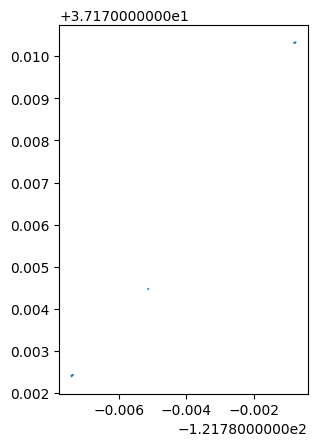

In [36]:
bfi.plot()
plt.show()

Check

In [94]:
fp = OUTPUT_FP
collected_footprints_file = os.path.join(fp, 'building_inferences')
building_footprints = gpd.read_file(collected_footprints_file)

In [95]:
building_footprints = assign_cbgs(building_footprints, cbg_sj)

In [96]:
#geoid = '060855079061'
geoid = cbg_sj.GEOID.unique()[507]

In [97]:
len(building_footprints.GEOID.unique())

619

In [125]:
building_footprints_cbg = building_footprints.loc[building_footprints['GEOID'] == geoid]

In [120]:
print(len(building_footprints_cbg))

1


In [121]:
building_footprints_cbg

,index_left,GEOID,tile,geometry
64843,15333.0,060855057004,/oak/stanford/groups/deho/building_compliance/...,"POLYGON ((-13574775.692 4486333.683, -13574774..."


In [103]:
cbg_file = os.path.join(fp, 'building_cbg_{}'.format(geoid))
cbg_geom = cbg_sj.loc[cbg_sj.GEOID == geoid].iloc[0]['geometry']

In [126]:
building_footprints_cbg = process_buildings(building_footprints_cbg, zoning_cbg, cbg_sj.crs, False)

/usr/local/lib/python3.8/dist-packages/geopandas/array.py:918: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/usr/local/lib/python3.8/dist-packages/geopandas/array.py:919: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/usr/local/lib/python3.8/dist-packages/geopandas/array.py:920: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/usr/local/lib/python3.8/dist-packages/geopandas/array.py:921: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy


In [128]:
# Compute area
building_footprints_cbg = compute_area(
    building_footprints_cbg, 180, None, cbg_sj.crs)



In [61]:
# Still have footprints in individual CBG file
building_footprints_cbg_saved = gpd.read_file(os.path.join(fp, 'building_cbg_{}'.format(geoid)))

In [62]:
print(len(building_footprints_cbg_saved))

460


<Figure size 640x480 with 0 Axes>

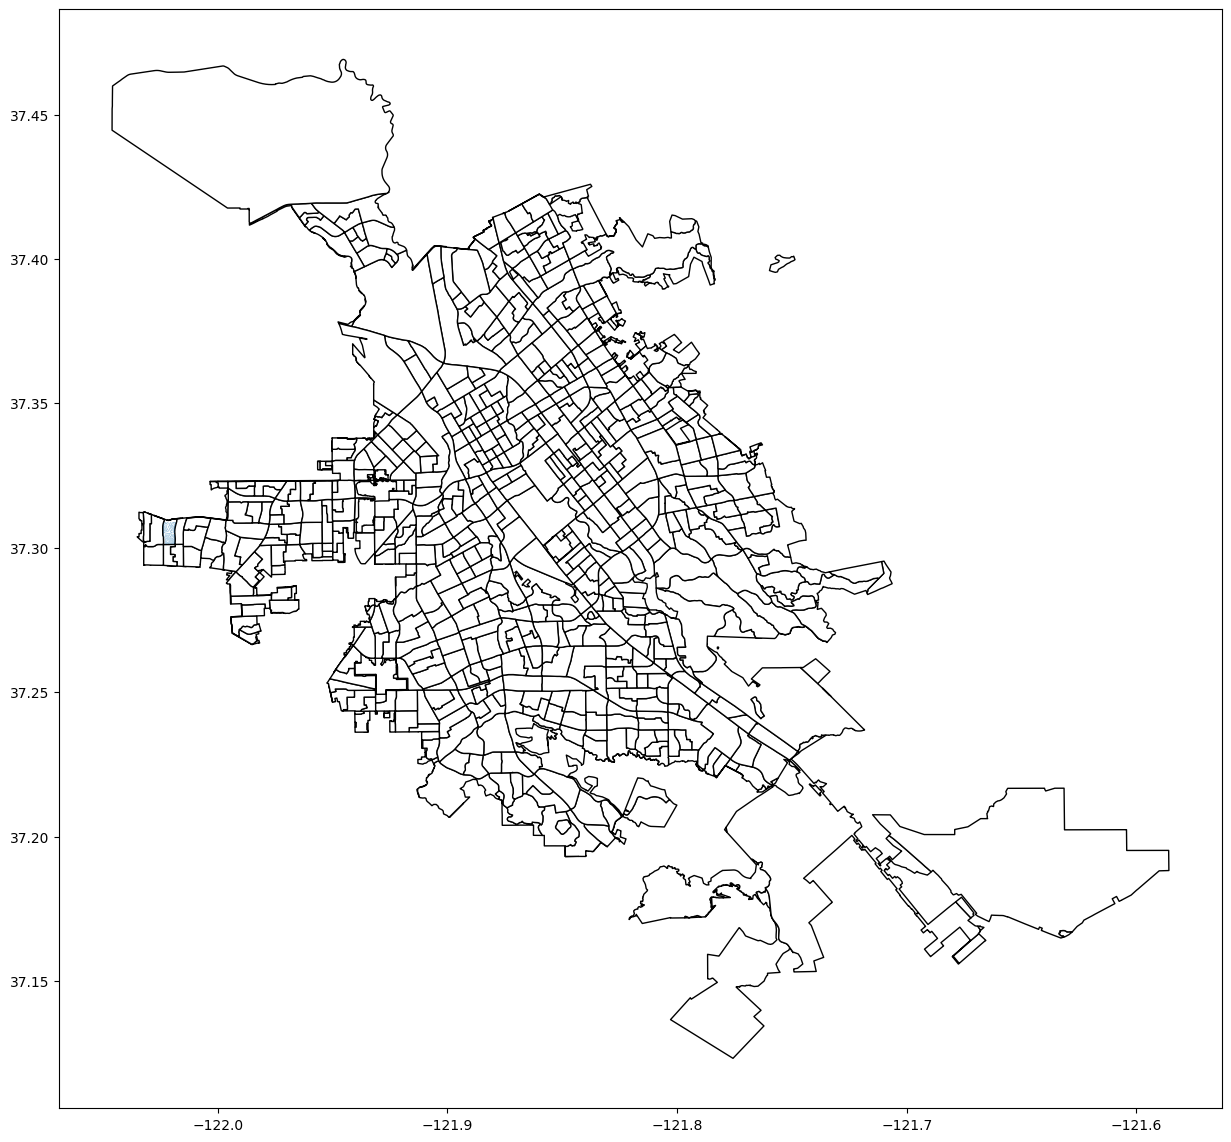

In [66]:
plt.clf()
fig = plt.figure(figsize=(15, 15))
ax = fig.gca()
ax.set_aspect('equal')
cbg_sj.plot(ax=ax, zorder=1, color='white', edgecolor="black")
#cbg_sj.loc[cbg_sj.GEOID == geoid].plot(ax=ax, zorder=2, color='green', edgecolor="black")
building_footprints_cbg_saved.plot(ax=ax, zorder=3, alpha=1)
plt.show()

In [88]:
# Footprints for the CBG do not appear in the final gdf 
building_footprints_final = gpd.read_file(os.path.join(fp, 'building_footprints_final'))

In [89]:
len(building_footprints_final.GEOID.unique())

618

In [90]:
building_footprints_final.head()

,area,small,large,GEOID,geometry
0,23.421297,1,0.0,060855122001,"POLYGON ((-121.76133 37.15183, -121.76133 37.1..."
1,32.308453,1,0.0,060855122001,"POLYGON ((-121.76122 37.15180, -121.76122 37.1..."
2,17.845765,1,0.0,060855122001,"POLYGON ((-121.76117 37.15177, -121.76117 37.1..."
3,25.538664,1,0.0,060855122001,"POLYGON ((-121.75529 37.16006, -121.75529 37.1..."
4,84.504147,1,0.0,060855122001,"POLYGON ((-121.75406 37.16017, -121.75406 37.1..."


In [91]:
building_footprints_final.loc[building_footprints_final['GEOID'] == geoid]

,area,small,large,GEOID,geometry
248397,305.153555,0,1.0,060855079061,"POLYGON ((-122.01896 37.30152, -122.01896 37.3..."
248398,398.357993,0,1.0,060855079061,"POLYGON ((-122.01893 37.30168, -122.01894 37.3..."
248399,317.309157,0,1.0,060855079061,"POLYGON ((-122.01909 37.30225, -122.01909 37.3..."
248400,359.518788,0,1.0,060855079061,"POLYGON ((-122.01890 37.30226, -122.01890 37.3..."
248401,399.590077,0,1.0,060855079061,"POLYGON ((-122.01906 37.30250, -122.01906 37.3..."
...,...,...,...,...,...
248852,350.546259,0,1.0,060855079061,"POLYGON ((-122.02219 37.30668, -122.02219 37.3..."
248853,503.874289,0,1.0,060855079061,"POLYGON ((-122.02310 37.30673, -122.02310 37.3..."
248854,331.938719,0,1.0,060855079061,"POLYGON ((-122.02128 37.30675, -122.02128 37.3..."
248855,377.401482,0,1.0,060855079061,"POLYGON ((-122.02283 37.30673, -122.02283 37.3..."


In [92]:
len(building_footprints_final)

252341

In [ ]:
252341

In [67]:
# Does not appear in CBG file
cbg_footprints = gpd.read_file(os.path.join(fp, 'cbg_inferences'))

In [68]:
cbg_footprints.loc[cbg_footprints['GEOID'] == geoid]

,GEOID,small,large,area,geometry


Visualize raw building footprints

In [ ]:
cbg = cbg_sj.GEOID.unique()[1]
building_footprints_cbg = building_footprints.loc[building_footprints['GEOID'] == cbg]

In [ ]:
plt.clf()
fig = plt.figure(figsize=(15, 15))
ax = fig.gca()
ax.set_aspect('equal')
cbg_sj.plot(ax=ax, zorder=1, color='white', edgecolor="black")
#cbg_sj.loc[cbg_sj.GEOID == cbg].plot(ax=ax, zorder=2, color='green', edgecolor="black")
building_footprints.plot(ax=ax, zorder=3, alpha=0.5)
plt.show()

In [ ]:
"""
def main(cbg_sj, zoning, inferences_dir, size, small_threshold, large_threshold, fp):

    # 1) Loop over each tile to convert the inference np.array to gpd
    # This step outputs a gpd of building footprints: building_footprints
    collected_footprints_file = os.path.join(fp, 'building_inferences')
    if not os.path.exists(collected_footprints_file):
        print('[INFO] Collecting building footprints')
        building_footprints = collect_inferences(inferences_dir, size, tif_fp)
        building_footprints.to_file(collected_footprints_file)
        print('[INFO] Number of buildings: {}'.format(len(building_footprints)))

    # 2) Vectorized processing of buildings at the cbg level using the gpd output from step 3
    #     - combine tile edge buildings
    #     - road filtering
    #     - building separation
    processed_footprints_file = os.path.join(fp, 'building_processed')
    if not os.path.exists(processed_footprints_file):
        print('[INFO] Loading building footprints')
        building_footprints = gpd.read_file(collected_footprints_file)
        print('[INFO] Number of buildings: {}'.format(len(building_footprints)))
        
        print('[INFO] Processing building footprints')
        building_footprints = process_buildings(building_footprints, zoning, cbg_sj.crs)
        building_footprints.to_file(processed_footprints_file)
        print('[INFO] Number of buildings: {}'.format(len(building_footprints)))

    # 3) assign buildings to CBGs
    final_footprints_file = os.path.join(fp, 'building_footprints_final')
    if not os.path.exists(final_footprints_file):
        print('[INFO] Loading processed buildings')
        building_footprints = gpd.read_file(processed_footprints_file)
        print('[INFO] Number of buildings: {}'.format(len(building_footprints)))
        
        print('[INFO] Assigning buildings to CBGs') 
        building_footprints = assign_cbgs(building_footprints, cbg_sj)

        # 4) Call gpd.geometry.area on the output from 4) using groupby with the cbg column
        # to get cbg-level area computations for large and small buildings
        print('[INFO] Computing building area')
        building_footprints = compute_area(building_footprints, small_threshold, large_threshold, cbg_sj.crs)
        
        print('[INFO] Generating CBG-level GeoDataFrame')
        cbg_footprints = building_footprints.groupby(['GEOID', 'small', 'large'])[['area']].sum().reset_index()

        # Add back geometry data to CBGs
        cbg_footprints = pd.merge(cbg_footprints, cbg_sj[['GEOID', 'geometry']], how='left', on='GEOID')

        print('[INFO] Exporting building and CBG shapefiles')
        building_footprints.to_file(final_footprints_file)
        cbg_footprints.to_file(os.path.join(fp, 'cbg_inferences'))
    else:
        print('[INFO] Loading building and CBG shapefiles')
        building_footprints = gpd.read_file(final_footprints_file)
        cbg_footprints = gpd.read_file(os.path.join(fp, 'cbg_inferences'))

        # 5) Visualize
        viz(cbg_sj, cbg_footprints, 'small', fp)
        viz(cbg_sj, cbg_footprints, 'large', fp)

    return building_footprints, cbg_footprints
"""

In [ ]:
# Verify SJ CBGs 
#plt.clf()
#fig = plt.figure(figsize=(15, 15))
#ax = fig.gca()
#ax.set_aspect('equal')
#cbg_scc.plot(ax=ax, zorder=1, color='white', edgecolor="black")
#cbg_sj.plot(ax=ax, zorder=2, color='red', alpha=0.5)
#sj_city.plot(ax=ax,  edgecolor='blue', zorder=3, alpha=0.3)
#plt.show()